# 1. Load Data

In [55]:
import csv
import os


def read_csv_file(file_path):
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist')
        return None
    with open(file_path) as f:
        reader = csv.reader(f)
        data = list(reader)
    return data


### Loading relative endpoints (interaction points) to the subject.


In [ ]:
# Plots all the points of the all_rel_chest_data folder
# structure of the csv file: pos_x, pos_y, pos_z, rot_x, rot_y, rot_z (3 times in one row)
def plot_all_rel_chest_data():
    all_x_z_data = []
    in_path = 'all_rel_chest_data/human_group/'
    for group_nr in range(1,11):
        group_path = in_path + f'Group{group_nr}/'
        for file in os.listdir(group_path):
            if file.endswith('.csv'):
                data = read_csv_file(group_path + file)
                # only get last 4 lines of data, since only these are interaction points
                data = data[-1:]                
                if data is None:
                    continue
                for row in data:
                    all_x_z_data.append([float(row[0]), float(row[2])])
    return all_x_z_data

In [ ]:
all_data = plot_all_rel_chest_data()

# 2. Create a KDE model.

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable



def KDE(X):
    X = np.asarray(X)  # Convert to NumPy array
    # Fit KDE model
    kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
    kde.fit(X)

    # Create a grid over the data range for evaluation
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    grid_samples = np.column_stack([xx.ravel(), yy.ravel()])

    # Evaluate density
    log_density = kde.score_samples(grid_samples)
    density = np.exp(log_density).reshape(xx.shape)
    print("log_density:", len(log_density))
    print("density:", len(density))


    # Use power-law normalization to enhance contrast
    norm = mcolors.PowerNorm(gamma=1)  # gamma < 1 boosts high values, compresses low

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(density, origin='lower', aspect='auto',
                extent=(x_min, x_max, y_min, y_max), cmap='viridis', norm=norm)
    ax.scatter(X[:, 0], X[:, 1], s=1, facecolor='white', alpha=0.4)
    # Set title and labels
    ax.set_title("Kernel Density Estimation (KDE) with Contrast")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Density")

    plt.tight_layout()
    plt.show()

        # Normalize density to [0, 1] over the full domain
    density_min = density.min()
    density_max = density.max()
    normalized_density = (density - density_min) / (density_max - density_min)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(normalized_density, origin='lower', aspect='auto',
                extent=(x_min, x_max, y_min, y_max), cmap='viridis', norm=norm)
    ax.scatter(X[:, 0], X[:, 1], s=1, facecolor='white', alpha=0.4)
    # Set title and labels
    ax.set_title("Kernel Density Estimation (KDE) for Positions of Interaction")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Density")

    plt.tight_layout()
    # Save to PNG
    # plt.savefig("kde.png", dpi=300)
    plt.show()

    return kde, log_density, density, normalized_density


    

log_density: 40000
density: 200


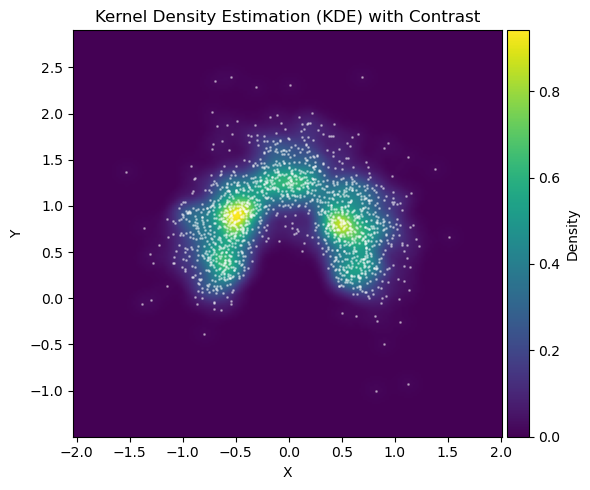

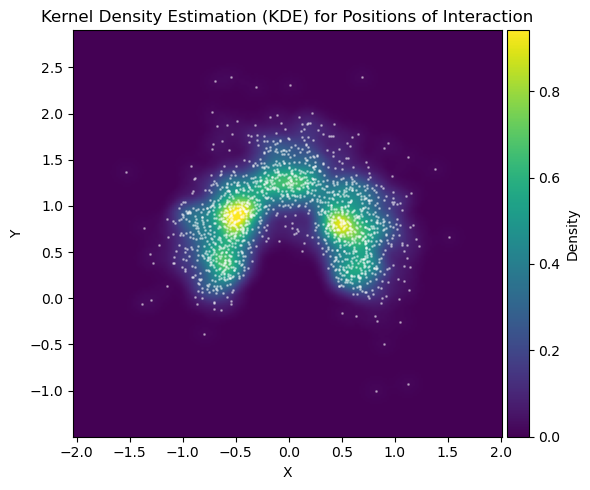

KernelDensity(bandwidth=0.2, kernel='linear')


In [170]:

kde, log, den, norm_den = KDE(all_data)
print(kde)

# 3. Save the learned KDE model.

In [ ]:
import joblib
joblib.dump(kde, "kde_model.pkl")

# Later:
# kde_loaded = joblib.load("kde_model.pkl")


# Visualization of Interaction-positions

In [ ]:
# Plot the data
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

all_data = np.array(all_data)

# Plots all the points of the all_rel_chest_data folder
plt.scatter(all_data[:,0], all_data[:,1], s=10, alpha=0.3)
plt.arrow(x=0, y=0, dx=0, dy=0.15, width=0.002, head_width=0.05, head_length=0.07, color='k', alpha=0.8)
# Plot the red dot at the origin
plt.plot(0, 0, 'ko', alpha=0.8)  # 'ro' = red circle

# Create proxy artists for the legend
arrow_proxy = Line2D([0], [0], color='k', marker=r'$\uparrow$', linestyle='None', alpha=0.8)
dot_proxy = Line2D([0], [0], color='k', marker='o', linestyle='None', alpha=0.8)

# Add legend with both entries
plt.legend([dot_proxy, arrow_proxy], ['Position of the Target Person', 'Front-facing Direction of the Target Person'])

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Positions of Interacting Individuals Relative to the Target Person')

# Save to PNG
plt.savefig("interaction_points.png", dpi=300)

plt.show()
